In [86]:
from datetime import datetime
import time
from decimal import Decimal, ROUND_DOWN
import os

import requests
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from starknet_py.net.gateway_client import GatewayClient
from starknet_py.net.full_node_client import FullNodeClient
from starknet_py.hash.selector import get_selector_from_name
from starknet_py.net.client_models import Call


# from aux import fetch_options


pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)
pd.set_option('display.max_columns', None)

In [ ]:
# Function for fetching options from our API
OPTIONS_ENDPOINT = 'https://api.carmine.finance/api/v1/mainnet/option-volatility'
def fetch_options():
    r = requests.get(OPTIONS_ENDPOINT)
    r.raise_for_status()
    return r.json()['data']

In [2]:
CALL = 0
PUT = 1

LONG = 0
SHORT = 1

In [3]:
AMM_ADDR = 0x076dbabc4293db346b0a56b29b6ea9fe18e93742c73f12348c8747ecfc1050aa
PRAGMA = 0x0346c57f094d641ad94e43468628d8e9c574dcb2803ec372576ccc60a40be2c4
TOKEN_ETH_ADDRESS = 0x049d36570d4e46f48e99674bd3fcc84644ddd6b96f7c741b1562b82f9e004dc7
TOKEN_USD_ADDRESS = 0x053c91253bc9682c04929ca02ed00b3e423f6710d2ee7e0d5ebb06f3ecf368a8


PRAGMA_MULT = Decimal(10**8) # Pragma price multiplier
FRACT_PART = Decimal(2**61)  # Math 64x61 multiplier
OPT_MULT = Decimal(10**18)   # Option token multiplier
ETH_MULT = Decimal(10**18)   # ETH multiplier
USDC_MULT = Decimal(10**6)   # USDC multiplier

In [4]:
NET = GatewayClient('mainnet')
async def func_call(addr, selector, calldata, note):
    call = Call(
        to_addr=addr,
        selector=get_selector_from_name(selector),
        calldata=calldata
    )
    res = await NET.call_contract(call)
    return (calldata, res, note)

async def func_call_from_block(addr, selector, calldata, note, block_num):
    call = Call(
        to_addr=addr,
        selector=get_selector_from_name(selector),
        calldata=calldata
    )
    res = await NET.call_contract(call, block_number=block_num)
    return (calldata, res, note)

In [5]:
opts = fetch_options()

# Convert all value to Decimal
for opt in opts:
    opt['strike_price'] = Decimal(int(opt['strike_price'], 16))

    for vol in opt['volatilities']:
        vol['volatility'] = Decimal(int(vol['volatility'], 16)) if vol['volatility'] is not None else None
        vol['option_position'] = Decimal(int(vol['option_position'], 16)) if vol['option_position'] is not None else None

### Amm Events

In [8]:
# Fetch AMM Events from Starkscan

url = 'https://api.starkscan.co/api/v0/events?from_address=0x076dbabc4293db346b0a56b29b6ea9fe18e93742c73f12348c8747ecfc1050aa&limit=100'

headers = {
    "accept": "application/json",
    "x-api-key": "INSERT STARKSCAN API KEY HERE",
    # "x-api-key": os.getenv('STARKSCAN_KEY'),
}

resps_amm_events = []

while True:
    response = requests.get(url, headers=headers)
    resps_amm_events.extend(response.json()['data'])
    url = response.json()['next_url']
    if not url:
        break
    time.sleep(0.1)


events = pd.DataFrame(resps_amm_events)

### Pool settlements
- Check that pools were settled at correct checkpoint where correct checkpoint means that either its timestamp is max 2 hours before expiry or that pools position was zero at the time of expiry (in this case nothing happens, so we don't care if the checkpoint wasn't the correct one)

In [10]:
# Select only pool expirations
pool_sets = events[events['key_name'] == 'ExpireOptionTokenForPool'].copy()

In [11]:
# Expand data column which stores event info
pool_sets['lp_token'] = [i[0] for i in pool_sets['data']]
pool_sets['side'] = [int(i[1], 16) for i in pool_sets['data']]
pool_sets['strike'] = [Decimal(int(i[2], 16)) for i in pool_sets['data']] # Convert to decimal
pool_sets['maturity'] = [int(i[3], 16) for i in pool_sets['data']]

pool_sets = pool_sets.drop('data', axis = 1)

In [12]:
pool_sets = pool_sets.to_dict('records')

In [ ]:
PRAGMA = 0x0346c57f094d641ad94e43468628d8e9c574dcb2803ec372576ccc60a40be2c4
selector = 'get_last_spot_checkpoint_before'
ETH_KEY = 19514442401534788

# Iterate over the pool settlements and add checkpoint timestamp/price that 
# would be received in the same block
for ix, settle in enumerate(pool_sets):

    print(f'Progress: {(ix+1) / len(pool_sets):_.2%}, {ix}')
    
    while True:
        try:
            res = await func_call_from_block(
                PRAGMA, # Address
                selector, # Selector
                [ETH_KEY, settle['maturity']], # Calldata - pair_id / timestamp(maturity in this case)
                None, # Note, not needed rn
                settle['block_number'] # Block number from which to retrieve the data
            )
            break 
        except KeyboardInterrupt:
            raise SystemExit
        except Exception as e:
            print(e)
            continue

    settle['price'] = Decimal(res[1][1]) # Convert to decimal
    settle['checkpoint_timestamp'] = res[1][0]


    settle['tm_diff'] = settle['maturity'] - settle['checkpoint_timestamp']
    settle['tm_diff_hours'] = settle['tm_diff'] / 3600

    settle['time'] = pd.to_datetime(settle['timestamp'], unit = 's').dt.strftime('%d/%m-%H:%M')

    settle['option_type'] = 0 if settle['lp_token'] == '0x7aba50fdb4e024c1ba63e2c60565d0fd32566ff4b18aa5818fc80c30e749024' else 1

    time.sleep(0.4)

In [19]:
for settle in pool_sets:
    option = None
    # Get corresponding option from api
    for opt in opts:
        if opt['option_side'] == settle['side']:
            if opt['option_type'] == settle['option_type']:
                if opt['maturity'] == settle['maturity']:
                    if opt['strike_price'] == settle['strike']:
                        # print(opt['strike_price'])
                        option = opt
    if option is None:
        print('Unable to find option')
        break

    # If the diff is between 0 and 2 then the settlement received correct checkpoint
    if settle['tm_diff_hours'] > 0 and settle['tm_diff_hours'] <= 2:
        settle['settled_correctly'] = True
        continue

    # However it does not matter if it settled with wrong checkpoint if the position was 0 at that time
    # so check pool position for given option in the block of settlement (and the one before to be sure)
    # and if it was 0 then we can say that it was setttled correctly   

    # Fetch data from block of settlement and the block before 
    while True:
        try:
            curr_res = await func_call_from_block(
                AMM_ADDR, # Address
                'get_option_position', # Selector
                [settle['lp_token'], settle['side'], settle['maturity'], settle['strike']], # Calldata
                None, # Note, not needed rn
                settle['block_number'] # Block number from which to retrieve the data
            )
            # Fetch data from block before settlement
            prev_res = await func_call_from_block(
                AMM_ADDR, # Address
                'get_option_position', # Selector
                [settle['lp_token'], settle['side'], settle['maturity'], settle['strike']], # Calldata
                None, # Note, not needed rn
                settle['block_number'] - 1 # Block number from which to retrieve the data
            )
            break
        except KeyboardInterrupt:
            raise SystemExit
        except Exception as e:
            # print(e)
            continue


    if curr_res[1][0] == 0 and prev_res[1][0] == 0:
        settle['settled_correctly'] = True 

    else: 
        print(':(')
        print("Fail curr: ", curr_res)
        print("Fail prev: ", prev_res)
        print('=====')
        settle['settled_correctly'] = False

In [20]:
pool_sets = pd.DataFrame(pool_sets)

In [21]:
# So it seems like the pools positions were always settled correctly
pool_sets[pool_sets['settled_correctly'] != True]

,block_hash,block_number,transaction_hash,event_index,from_address,keys,timestamp,key_name,lp_token,side,strike,maturity,price,checkpoint_timestamp,tm_diff,tm_diff_hours,time,option_type,settled_correctly


In [22]:
# Store correct prices
correct_prices = (
    pool_sets[(pool_sets['tm_diff_hours']>0) & (pool_sets['tm_diff_hours'] < 2)]
        .drop_duplicates(subset = 'maturity')[['maturity', 'price']]
        .set_index('maturity')
        .to_dict()['price']
)

In [23]:
correct_prices

{1690502399: Decimal('185698750000'),
 1689897599: Decimal('189295959355'),
 1689292799: Decimal('199634999999'),
 1688687999: Decimal('185965250000'),
 1688083199: Decimal('185376388188'),
 1687478399: Decimal('187489594018'),
 1686873599: Decimal('166757789406'),
 1686268799: Decimal('184823500000'),
 1685663999: Decimal('186833000000'),
 1685059199: Decimal('180766093714'),
 1683244799: Decimal('187700133191'),
 1682035199: Decimal('193971440763'),
 1684454399: Decimal('180575000000')}

In [24]:
# Just make backup in case full data are needed down the road
pool_sets_bkp = pool_sets.copy() 

# Let's just filter settlements with incorrect checkpoints
pool_sets = pool_sets[(pool_sets['tm_diff_hours'] > 0) & (pool_sets['tm_diff_hours'] < 2)]

# And convert df to records for easier access down the road
pool_sets = pool_sets.to_dict('records')

In [ ]:
# pool_sets_bkp.to_csv('pool_sets_bkp.csv')

### User settlements
- First pull checkpoint from the same (and previous) block which user has settled their position in. Then compare it against the price of the checkpoint which pool has used to settle their option. If it's the same then thats good, if not then it's fukd.

In [25]:
_user_sets = events[events['key_name'] == 'TradeSettle'].copy()

In [26]:
# Expand data column which stores event info
_user_sets['caller'] = [i[0] for i in _user_sets['data']]
_user_sets['opt_addr'] = [int(i[1], 16) for i in _user_sets['data']]
_user_sets['capital_transfered'] = [Decimal(int(i[2], 16)) for i in _user_sets['data']]
_user_sets['opt_burned'] = [Decimal(int(i[4], 16)) for i in _user_sets['data']]

_user_sets = _user_sets.drop('data', axis = 1)

In [27]:
_user_sets = _user_sets.to_dict('records') # For easier iteration

In [28]:
_user_sets[1]

{'block_hash': '0x0203ddac0db060f54390c9418b6cbd823be7c2b777dfa078bfef0b420c9f9328',
 'block_number': 136184,
 'transaction_hash': '0x0613cfae5420a03f3743df3c87ae4ab4b25dcb0f74cde0c1995536dcb484a6f7',
 'event_index': 2,
 'from_address': '0x076dbabc4293db346b0a56b29b6ea9fe18e93742c73f12348c8747ecfc1050aa',
 'keys': ['0x1b012be10df8edf74fad801c1ee1f65a229fd1ca889edd3b375bc3240777124'],
 'timestamp': 1690778613,
 'key_name': 'TradeSettle',
 'caller': '0x18c9b09701296925480e4464d7f46eec9507feefc2df5d2cd5a5d05a0cea683',
 'opt_addr': 3108252820798498058769758588913584259610781601970447807813391789746798662574,
 'capital_transfered': Decimal('2150624'),
 'opt_burned': Decimal('50000000000000000')}

In [ ]:
PRAGMA = 0x0346c57f094d641ad94e43468628d8e9c574dcb2803ec372576ccc60a40be2c4
selector = 'get_last_spot_checkpoint_before'
ETH_KEY = 19514442401534788

# Iterate over the user settlements and add checkpoint timestamp/price that 
# would be received in the same and previous/next block
for ix, settle in enumerate(_user_sets):

    print(f'Progress: {(ix+1) / len(_user_sets):_.2%}, {ix}')
    
    # User settlement event do not come with maturity etc so let's add it
    for opt in opts:
        if hex(int(opt['option_address'], 0)) == hex(settle['opt_addr']):
            settle['maturity'] = opt['maturity']
            settle['side'] = opt['option_side']
            settle['strike'] = opt['strike_price']
            settle['option_type'] = opt['option_type']

    # Also let's add the correct price of settlement
    settle['pool_price'] = correct_prices[settle['maturity']]
    
    while True:
        try: 
            curr_res = await func_call_from_block( # Checkpoint in current block
                PRAGMA, # Address
                selector, # Selector
                [ETH_KEY, settle['maturity']], # Calldata - pair_id / timestamp(maturity in this case)
                None, # Note, not needed rn
                settle['block_number'] # Block number from which to retrieve the data
            )
            prev_res = await func_call_from_block( # Checkpoint in previous block
                PRAGMA,
                selector, 
                [ETH_KEY, settle['maturity']], 
                None, 
                settle['block_number'] - 1 
            )
            next_res = await func_call_from_block( # Checkpoint in next block
                PRAGMA, 
                selector, 
                [ETH_KEY, settle['maturity']], 
                None, 
                settle['block_number'] + 1 
            )

            break
        except KeyboardInterrupt:
            raise SystemExit
        except Exception as e:
            # print(e)
            print('repeating: ', ix)
            time.sleep(1)
            continue
    
    settle['curr_price'] = Decimal(curr_res[1][1])
    settle['curr_checkpoint_timestamp'] = curr_res[1][0]

    settle['prev_price'] = Decimal(prev_res[1][1])
    settle['prev_checkpoint_timestamp'] = prev_res[1][0]
    
    settle['next_price'] = Decimal(next_res[1][1])
    settle['next_checkpoint_timestamp'] = next_res[1][0]

    time.sleep(0.4)

In [30]:
user_sets = pd.DataFrame(_user_sets)

In [31]:
user_sets.head()

,block_hash,block_number,transaction_hash,event_index,from_address,keys,timestamp,key_name,caller,opt_addr,capital_transfered,opt_burned,maturity,side,strike,option_type,pool_price,curr_price,curr_checkpoint_timestamp,prev_price,prev_checkpoint_timestamp,next_price,next_checkpoint_timestamp
0,0x03118b4c095d386a50b93a0950a54aef7a9164159f51cceefc072721ff946a80,136699,0x03437ed02747b7258114033cd785e7fed3e44551e17325df4b18d0bb873d287d,2,0x076dbabc4293db346b0a56b29b6ea9fe18e93742c73f12348c8747ecfc1050aa,[0x1b012be10df8edf74fad801c1ee1f65a229fd1ca889edd3b375bc3240777124],1690800408,TradeSettle,0x382ddc2625629d2aaabd6f032f53353ab9930c4a2a7ebe50a3a308e51badc36,512606146535035406613588731157100718044554687953824380160684396980085738440,599999999999999999,600000000000000000,1690502399,1,4611686018427387904000,0,185698750000,185698750000,1690500472,185698750000,1690500472,185698750000,1690500472
1,0x0203ddac0db060f54390c9418b6cbd823be7c2b777dfa078bfef0b420c9f9328,136184,0x0613cfae5420a03f3743df3c87ae4ab4b25dcb0f74cde0c1995536dcb484a6f7,2,0x076dbabc4293db346b0a56b29b6ea9fe18e93742c73f12348c8747ecfc1050aa,[0x1b012be10df8edf74fad801c1ee1f65a229fd1ca889edd3b375bc3240777124],1690778613,TradeSettle,0x18c9b09701296925480e4464d7f46eec9507feefc2df5d2cd5a5d05a0cea683,3108252820798498058769758588913584259610781601970447807813391789746798662574,2150624,50000000000000000,1690502399,0,4381101717506018508800,1,185698750000,185698750000,1690500472,185698750000,1690500472,185698750000,1690500472
2,0x043f2e3d10e2401481ea62dd5281352d724d093c429386b62d0d17604654eb6e,136034,0x07698cee0a3604f3d1b3273cf53cd8d228958cd3603372942eb8846fc5fb48e5,2,0x076dbabc4293db346b0a56b29b6ea9fe18e93742c73f12348c8747ecfc1050aa,[0x1b012be10df8edf74fad801c1ee1f65a229fd1ca889edd3b375bc3240777124],1690770494,TradeSettle,0x79cb8b800ed7ea51635e0da7ffff66caedab80fee194f0dfd9c7be4c3948929,18392177853797718284672388600717979808133134892588090837118818709377857977,0,2000000000000000,1689292799,0,4611686018427387904000,0,199634999999,199634999999,1689290873,199634999999,1689290873,199634999999,1689290873
3,0x038d1cb92533e90cf54bae03766f5ac08e6d1dfd8d19603c71b12e56d0f54158,135914,0x065c0d47b046ba9d156b6ed590e40dba449342da30a74bd71f43e4967b2dba5a,2,0x076dbabc4293db346b0a56b29b6ea9fe18e93742c73f12348c8747ecfc1050aa,[0x1b012be10df8edf74fad801c1ee1f65a229fd1ca889edd3b375bc3240777124],1690759809,TradeSettle,0x7fb63b1f935ebdd313d67f813727697f97358e6ac14611c6637d58aa96a2a78,3108252820798498058769758588913584259610781601970447807813391789746798662574,860249,20000000000000000,1690502399,0,4381101717506018508800,1,185698750000,185698750000,1690500472,185698750000,1690500472,185698750000,1690500472
4,0x038d1cb92533e90cf54bae03766f5ac08e6d1dfd8d19603c71b12e56d0f54158,135914,0x07237b07af3d7e8b4a791820e46a3cd06e8ec53b099028d81c6eb7629bea0832,2,0x076dbabc4293db346b0a56b29b6ea9fe18e93742c73f12348c8747ecfc1050aa,[0x1b012be10df8edf74fad801c1ee1f65a229fd1ca889edd3b375bc3240777124],1690759809,TradeSettle,0x7fb63b1f935ebdd313d67f813727697f97358e6ac14611c6637d58aa96a2a78,901764646050036611057278582447568327155978676050043336635190293075884933316,0,26000000000000000,1684454399,0,4150517416584649113600,1,180575000000,180575000000,1684452462,180575000000,1684452462,180575000000,1684452462


In [32]:
# Make sure that checkpoint price was the same for previous and next block compared to current one
(
    (user_sets['curr_price'] == user_sets['prev_price']) & 
    (user_sets['curr_price'] == user_sets['next_price'])
).sum() == len(user_sets)

True

In [33]:
# Make sure that checkpoint timestamp was the same for previous a next block compared to current one
(
    (user_sets['curr_checkpoint_timestamp'] == user_sets['prev_checkpoint_timestamp']) & 
    (user_sets['curr_checkpoint_timestamp'] == user_sets['next_checkpoint_timestamp'])
).sum() == len(user_sets)

True

In [35]:
user_sets['curr_chkp_tm_diff_hours'] = (user_sets['maturity'] - user_sets['curr_checkpoint_timestamp'])/3600

In [36]:
user_sets['curr_chkp_tm_diff_hours'].describe()

count    732.000000
mean      -5.261006
std       22.410130
min     -167.001667
25%        0.535000
50%        0.535278
75%        0.538056
max        1.235000
Name: curr_chkp_tm_diff_hours, dtype: float64

<Axes: ylabel='Frequency'>

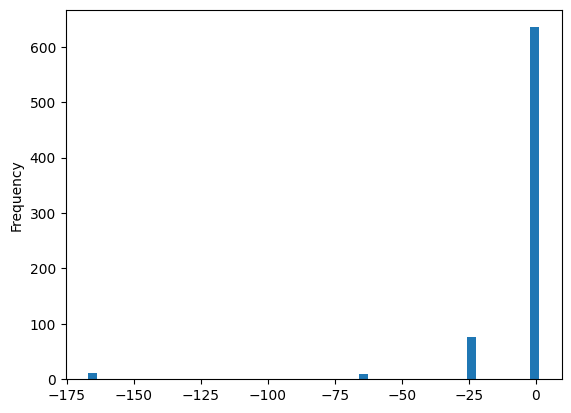

In [37]:
user_sets['curr_chkp_tm_diff_hours'].plot.hist(bins=50)

In [38]:
# Just a quick check that every settlement with good checkpoint had correct price
tmp = user_sets[user_sets['curr_chkp_tm_diff_hours'] >= 0]

(tmp['pool_price']  - tmp['curr_price']).sum()

Decimal('0')

In [83]:
# user_sets.to_csv('user_sets.csv')

In [39]:
user_bad_sets = user_sets[user_sets['curr_chkp_tm_diff_hours'] < 0].copy()

In [40]:
user_bad_sets['curr_chkp_tm_diff_hours'].describe()

count     97.000000
mean     -43.542655
std       46.010073
min     -167.001667
25%      -23.461944
50%      -23.001667
75%      -23.001389
max      -23.001389
Name: curr_chkp_tm_diff_hours, dtype: float64

In [41]:
user_bad_sets['pool_price_diff'] = user_bad_sets['pool_price'] - user_bad_sets['curr_price']

In [42]:
# There is no incorrectly settled trade that would accidentally happen to have the same price as pool :(((
print(abs(user_bad_sets['pool_price_diff']).min())
user_bad_sets[user_bad_sets['pool_price_diff'] == 0]

763000000


,block_hash,block_number,transaction_hash,event_index,from_address,keys,timestamp,key_name,caller,opt_addr,capital_transfered,opt_burned,maturity,side,strike,option_type,pool_price,curr_price,curr_checkpoint_timestamp,prev_price,prev_checkpoint_timestamp,next_price,next_checkpoint_timestamp,curr_chkp_tm_diff_hours,pool_price_diff


In [43]:
user_bad_sets = user_bad_sets.to_dict('records')

In [44]:
# We can filter out some more stuff
user_loss_sets = []
for settle in user_bad_sets:
    
    if settle['option_type'] == 0: # Call
        if ((settle['curr_price'] / PRAGMA_MULT) < (settle['strike'] / FRACT_PART)) and ((settle['pool_price'] / PRAGMA_MULT) < (settle['strike'] / FRACT_PART)):
            # In this case user might've received incorrect price but
            # since the correct price was under the strike as well then we don't really care
            # since correct price wouldn't change the outcome anyway
            # For long call, user would've already paid the premia and since the option expired OTM,
            # There is nothing we would've paid to anyway
            # If the user was short, then he already paid the premia and the capital they put into 
            # the pool would've been released to them no matter how low the price was below the strike
            continue
        else:
            user_loss_sets.append(settle)
    
    elif settle['option_type'] == 1: # Put
        if ((settle['curr_price'] / PRAGMA_MULT) > (settle['strike'] / FRACT_PART)) and ((settle['pool_price'] / PRAGMA_MULT) > (settle['strike'] / FRACT_PART)):
            # In this case we again don't care since long put user would not receive anythig anyway
            # While short put user would receive all of their capital back no matter how much the price is above the strike
            continue
        else:
            user_loss_sets.append(settle)
    else:
        print("How did we get here?")



In [45]:
user_loss_sets = pd.DataFrame(user_loss_sets)

In [46]:
def get_payoff(row: pd.Series, price: str):

    if row['option_type'] == 0: # Call
        if row['side'] == 0: # Long
            return (row['opt_burned'] / OPT_MULT) * max(0, ((row[price] / PRAGMA_MULT) - (row['strike'])/FRACT_PART) / (row[price] / PRAGMA_MULT)) * ETH_MULT
        elif row['side'] == 1: # Short
            return (row['opt_burned'] / OPT_MULT) * (1 - max(0, ((row[price] / PRAGMA_MULT) - (row['strike']) / FRACT_PART) / (row[price] / PRAGMA_MULT))) * ETH_MULT
        else:
            print("How did we get here?")
    
    elif row['option_type'] == 1: # Put
        if row['side'] == 0: # Long
            return (row['opt_burned'] / OPT_MULT) * max(0, (row['strike'] / FRACT_PART) - (row[price] / PRAGMA_MULT)) * USDC_MULT
        elif row['side'] == 1: # Short
            return (row['opt_burned'] / OPT_MULT) * min((row['strike'] / FRACT_PART), (row[price] / PRAGMA_MULT)) * USDC_MULT
        else: 
            print('How did we get here?')
    else:
        print('How did we get here?')

In [47]:
user_loss_sets['calc_received_payoff'] = user_loss_sets.apply(lambda x: get_payoff(x, 'curr_price'), axis = 1)
user_loss_sets['should_receive_payoff'] = user_loss_sets.apply(lambda x: get_payoff(x, 'pool_price'), axis = 1)
# user_loss_sets['capital_transfered'] = user_loss_sets.apply(lambda x: x['capital_transfered'] / 10**18 if x['option_type'] == 0 else x['capital_transfered'] / 10**6, axis = 1)

In [48]:
user_loss_sets['calc_received_payoff'] = user_loss_sets['calc_received_payoff'].map(lambda x: x.quantize(Decimal('1.'), ROUND_DOWN))
user_loss_sets['should_receive_payoff'] = user_loss_sets['should_receive_payoff'].map(lambda x: x.quantize(Decimal('1.'), ROUND_DOWN))

In [49]:
user_loss_sets[['side', 'option_type', 'maturity', 'strike', 'curr_price', 'pool_price', 'opt_burned', 'capital_transfered', 'calc_received_payoff', 'should_receive_payoff']]

,side,option_type,maturity,strike,curr_price,pool_price,opt_burned,capital_transfered,calc_received_payoff,should_receive_payoff
0,0,0,1687478399,4150517416584649113600,189307847241,187489594018,100000000000000000,4916778346304135,4916778346304136,3994671841510819
1,0,0,1687478399,3919933115663279718400,189307847241,187489594018,1000000000000000,101991795492872,101991795492872,93283011836491
2,0,0,1686873599,4150517416584649113600,187520500000,166757789406,1000000000000000000,40104948525627864,40104948525627864,0
3,0,0,1686873599,4150517416584649113600,187520500000,166757789406,9000000000000000000,360944536730650781,360944536730650782,0
4,1,1,1686873599,4150517416584649113600,187520500000,166757789406,1000000000000000000,1800000000,1800000000,1667577894
5,0,0,1686873599,4150517416584649113600,187520500000,166757789406,10000000000000000,401049485256278,401049485256278,0
6,0,0,1685059199,4150517416584649113600,182871201931,180766093714,3000000000000000,47102035214106,47102035214106,12714116318938
7,0,0,1686268799,4150517416584649113600,174525860087,184823500000,1000000000000000,0,0,26097871753321
8,0,0,1686268799,4150517416584649113600,174525860087,184823500000,1000000000000000,0,0,26097871753321
9,0,0,1686268799,4150517416584649113600,174525860087,184823500000,1000000000000000,0,0,26097871753321


In [100]:
# user_loss_sets.to_csv('user_loss_sets.csv')

In [101]:
loss_c = user_loss_sets[user_loss_sets['option_type'] == CALL].copy()
loss_p = user_loss_sets[user_loss_sets['option_type'] == PUT].copy()

In [112]:
# Amm losses 
amm_loss_c = (loss_c['calc_received_payoff'] - loss_c['should_receive_payoff'])
print("AMM loses: ", amm_loss_c.sum() / ETH_MULT, 'ETH')

# User lossesj
user_loss_c = loss_c[loss_c['capital_transfered'] < loss_c['should_receive_payoff']].copy()
user_loss_c['loss'] = user_loss_c.eval("should_receive_payoff - capital_transfered")
print("User losses: ",  user_loss_c['loss'].sum() / ETH_MULT, 'ETH')

# User excessive gains
user_gains_c = loss_c[loss_c['capital_transfered'] > loss_c['should_receive_payoff']].copy()
user_gains_c['gain'] = user_gains_c.eval("capital_transfered - should_receive_payoff")
print("User gains: ", user_gains_c['gain'].sum() / ETH_MULT, 'ETH')

AMM loses:  0.357060926227151829 ETH
User losses:  0.046256204706354491 ETH
User gains:  0.403317130933506318 ETH


In [138]:
amm_loss_c.sum()

357060926227151829

In [132]:
# Amm losses 
amm_loss_p = (loss_p['calc_received_payoff'] - loss_p['should_receive_payoff'])
print("AMM loses: ", amm_loss_p.sum() / USDC_MULT, 'USDC')

# User losses
user_loss_p = loss_p[loss_p['capital_transfered'] < loss_p['should_receive_payoff']].copy()
user_loss_p['loss'] = user_loss_p.eval("should_receive_payoff - capital_transfered")
print("User losses: ",  user_loss_p['loss'].sum() / USDC_MULT, 'USDC')

# User excessive gains
user_gains_p = loss_p[loss_p['capital_transfered'] > loss_p['should_receive_payoff']].copy()
user_gains_p['gain'] = user_gains_p.eval("capital_transfered - should_receive_payoff")
print("User gains: ", user_gains_p['gain'].sum() / USDC_MULT, 'USDC')

AMM loses:  199.06771 USDC
User losses:  47.14587 USDC
User gains:  246.213573 USDC


In [137]:
amm_loss_p.sum()

199067710

In [136]:
# user_loss_p[['caller', 'loss']].set_index('caller').to_csv('user_losses_USDC.csv')

In [131]:
# user_loss_c[['caller', 'loss']].set_index('caller').to_csv('user_losses_ETH.csv')

### Sanity Checks

##### Lpool balances

In [5]:

url = 'https://api.starkscan.co/api/v0/events?from_address=0x076dbabc4293db346b0a56b29b6ea9fe18e93742c73f12348c8747ecfc1050aa&limit=100'

headers = {
    "accept": "application/json",
    "x-api-key": "yKIwKIEUPu4tEBVeLg003MmDm7CuPeg2FBC8oLH8",
}

resps_amm_events = []

while True:
    response = requests.get(url, headers=headers)
    resps_amm_events.extend(response.json()['data'])
    url = response.json()['next_url']
    if not url:
        break
    time.sleep(0.1)


events = pd.DataFrame(resps_amm_events)

pool_sets = events[events['key_name'] == 'ExpireOptionTokenForPool'].copy()
pool_sets['lp_token'] = [i[0] for i in pool_sets['data']]
pool_sets['side'] = [int(i[1], 16) for i in pool_sets['data']]
pool_sets['strike'] = [Decimal(int(i[2], 16)) for i in pool_sets['data']] # Convert to decimal
pool_sets['maturity'] = [int(i[3], 16) for i in pool_sets['data']]
pool_sets = pool_sets.to_dict('records')


opts = fetch_options()

# Convert all value to Decimal
for opt in opts:
    opt['strike_price'] = Decimal(int(opt['strike_price'], 16))

    for vol in opt['volatilities']:
        vol['volatility'] = Decimal(int(vol['volatility'], 16)) if vol['volatility'] is not None else None
        vol['option_position'] = Decimal(int(vol['option_position'], 16)) if vol['option_position'] is not None else None
                                                 


lpools = {i['lp_token'] for i in pool_sets}

# Add lpool balances
lpools = [
    {
        'lp_token': i, 
        'lpool_balance': Decimal((await func_call(AMM_ADDR, 'get_lpool_balance', [i], None))[1][0]),
        'option_type': 0 if i == '0x7aba50fdb4e024c1ba63e2c60565d0fd32566ff4b18aa5818fc80c30e749024' else 1
    }
    for i in lpools
]

# Add real balances
for i in lpools:
    i.update(
        {
            'real_balance': Decimal(
                (await func_call(TOKEN_ETH_ADDRESS if i['option_type'] == 0 else TOKEN_USD_ADDRESS, 'balanceOf', [AMM_ADDR], None))[1][0]
            )
        }
    )

In [6]:
lpools

[{'lp_token': '0x7aba50fdb4e024c1ba63e2c60565d0fd32566ff4b18aa5818fc80c30e749024',
  'lpool_balance': Decimal('32370981691650588891'),
  'option_type': 0,
  'real_balance': Decimal('50427361556382655738')},
 {'lp_token': '0x18a6abca394bd5f822cfa5f88783c01b13e593d1603e7b41b00d31d2ea4827a',
  'lpool_balance': Decimal('54850593053'),
  'option_type': 1,
  'real_balance': Decimal('55492542997')}]

##### Unsettled profit in expired options

In [7]:
call_opts = [i for i in opts if i['option_type'] == CALL]
put_opts = [i for i in opts if i['option_type'] == PUT]

# # Fetch supplies
for opt in call_opts:
    while True:
        try:
            res  = await func_call(int(opt['option_address'], 16), 'totalSupply', [], None)
            opt['supply'] = Decimal(res[1][0])
            break
        except KeyboardInterrupt:
            break
        except Exception as e:
            # print(e)
            continue



for opt in put_opts:
    while True:
        try:
            res  = await func_call(int(opt['option_address'], 16), 'totalSupply', [], None)
            opt['supply'] = Decimal(res[1][0])
            break
        except KeyboardInterrupt:
            break
        except Exception as e:
            # print(e)
            continue

In [8]:
n = time.time()

call_opts_exp = [i for i in call_opts if i['maturity'] <= n]
put_opts_exp = [i for i in put_opts if i['maturity'] <= n]

correct_prices = {
    1690502399: Decimal('185698750000'),
    1689897599: Decimal('189295959355'),
    1689292799: Decimal('199634999999'),
    1688687999: Decimal('185965250000'),
    1688083199: Decimal('185376388188'),
    1687478399: Decimal('187489594018'),
    1686873599: Decimal('166757789406'),
    1686268799: Decimal('184823500000'),
    1685663999: Decimal('186833000000'),
    1685059199: Decimal('180766093714'),
    1683244799: Decimal('187700133191'),
    1682035199: Decimal('193971440763'),
    1684454399: Decimal('180575000000')
}

# Add price at expiry 
for opt in call_opts_exp:
    opt['exp_price'] = correct_prices[opt['maturity']]

for opt in put_opts_exp:
    opt['exp_price'] = correct_prices[opt['maturity']]

In [9]:
# Get payoffs on unsettled options
for opt in call_opts_exp: 
    if opt['option_side'] == 0: # Long
        opt['payoff'] = (opt['supply'] / OPT_MULT) * max(0, ((opt['exp_price'] / PRAGMA_MULT) - (opt['strike_price']) / FRACT_PART) / (opt['exp_price'] / PRAGMA_MULT)) * ETH_MULT
    elif opt['option_side'] == 1: # Short
        opt['payoff'] =  (opt['supply'] / OPT_MULT) * (1 - max(0, ((opt['exp_price'] / PRAGMA_MULT) - (opt['strike_price']) / FRACT_PART) / (opt['exp_price'] / PRAGMA_MULT))) * ETH_MULT
    else:
        print("How did we get here?")

    opt['payoff'] = opt['payoff'].quantize(Decimal('1.'), ROUND_DOWN)

for opt in put_opts_exp:
    if opt['option_side'] == 0: # Long
        opt['payoff'] = (opt['supply'] / OPT_MULT) * max(0, (opt['strike_price'] / FRACT_PART) - (opt['exp_price'] / PRAGMA_MULT)) * USDC_MULT
    elif opt['option_side'] == 1: # Short
        opt['payoff'] = (opt['supply'] / OPT_MULT) * min((opt['strike_price'] / FRACT_PART), (opt['exp_price'] / PRAGMA_MULT)) * USDC_MULT
    else: 
        print('How did we get here?')

    opt['payoff'] = opt['payoff'].quantize(Decimal('1.'), ROUND_DOWN)


#### Unexpired options

In [10]:
trades = events[events['key_name'].isin(['TradeOpen', 'TradeClose'])].copy()

trades['option_token']       = [i[1] for i in trades['data']]
trades['capital_transfered'] = [i[2] for i in trades['data']]
trades['opt_change']         = [i[4] for i in trades['data']]

trades = trades[['timestamp', 'key_name', 'option_token', 'capital_transfered', 'opt_change']].to_dict('records')

for trade in trades:
    matching_option = None
    for opt in opts:
        if int(trade['option_token'], 16) == int(opt['option_address'], 16):
            matching_option = opt

    if matching_option is None:
        print('Unable to find option for trade:', trade)
        break 

    # Convert to decimals
    trade['capital_transfered'] = Decimal(int(trade['capital_transfered'], 16))
    trade['opt_change'] = Decimal(int(trade['opt_change'], 16))

    # Get option specs
    trade['maturity'] = matching_option['maturity']
    trade['strike_price'] = matching_option['strike_price']
    trade['option_side'] = matching_option['option_side']
    trade['option_type'] = matching_option['option_type']

In [67]:
# Select only trades on unexpired options
trades = [
    i for i in trades
    if i['maturity'] >= n
]

# Calculate adjustments to balanceof amm

for trade in trades:

    if trade['option_side'] == 0:
        # Both balanceOf and lpool balance are increased(for TradeOpen, decreased for TradeClose) by long premia paid
        # so no adjustments are needed
        trade['adjust_balanceOf_by'] = Decimal(0)
    
    elif trade['option_side'] == 1: 
        # For TradeOpen, both balanceOf and lpool balance are decreased by short premium received 
        # but balance is increased by option size on top of that, so we need to substract that

        # While for TradeClose both balanceOf and lpool balance are increased by premia with fees,
        # however now we need to adjust by adding option_size

        if trade['option_type'] == 0:
            # Call tokens have same amount of decimals as 
            # trade['adjust_balanceOf_by'] = trade['opt_change']
            trade['adjust_balanceOf_by'] = -trade['opt_change'] if trade['key_name'] == 'TradeOpen' else trade['opt_change']

        if trade['option_type'] == 1:
            # Put tokens don't - we have to convert from opt to usdc 
            # Also we have to multiply by strike price 
            adjustment = -trade['opt_change'] if trade['key_name'] == 'TradeOpen' else trade['opt_change']
            trade['adjust_balanceOf_by'] = adjustment / OPT_MULT * USDC_MULT * trade['strike_price'] / FRACT_PART

    else: 
        print('How did we get here?', trade)


call_trades = [i for i in trades if i['option_type'] == CALL]
put_trades = [i for i in trades if i['option_type'] == PUT]

In [70]:
# Copied
amm_loss_c = Decimal('357060926227151829')
amm_loss_p = Decimal('199067710')

### All together

In [71]:
lpools

[{'lp_token': '0x7aba50fdb4e024c1ba63e2c60565d0fd32566ff4b18aa5818fc80c30e749024',
  'lpool_balance': Decimal('32370981691650588891'),
  'option_type': 0,
  'real_balance': Decimal('50427361556382655738')},
 {'lp_token': '0x18a6abca394bd5f822cfa5f88783c01b13e593d1603e7b41b00d31d2ea4827a',
  'lpool_balance': Decimal('54850593053'),
  'option_type': 1,
  'real_balance': Decimal('55492542997')}]

In [96]:
sum(i['payoff'] for i in call_opts_exp) / ETH_MULT

Decimal('3.026461790959218462')

In [97]:
sum(i['payoff'] for i in put_opts_exp) / USDC_MULT

Decimal('837.121182')

In [82]:
res_call = (
      lpools[0]['real_balance'] # balanceOf (ie ETH)
    - lpools[0]['lpool_balance'] # Lpool balance storage var
    - sum(i['payoff'] for i in call_opts_exp) # Payoff that hasn't been yet settled
    + sum(i['adjust_balanceOf_by'] for i in call_trades) # From trades on non-expired optionsns
    + amm_loss_c # Loss from oracle bug
) 
res_call / ETH_MULT

Decimal('2.14E-16')

In [83]:
res_put = (
      lpools[1]['real_balance'] 
    - lpools[1]['lpool_balance'] 
    - sum(i['payoff'] for i in put_opts_exp)
    + sum(i['adjust_balanceOf_by'] for i in put_trades)
    + amm_loss_p 
)
res_put / USDC_MULT

Decimal('0.000072')

In [ ]:
# Note that error is basically a positive zero, and some small rounding errors that leave little bit in the amm 
# are expected

# So it seems like the losses calculated are correct and thus 
# total loss is around 0.403 ETH and around 246.21 USDC
# where AMM is missing around 0.357 ETH and 199.067 USDC
# while users are missing around 0.046 ETH and 47 USDC